# Project Overview

## Context  
Spotify's music streaming service allows users to create personalized playlists and manage family accounts.  
In November 2021, a server hack deleted users’ Top-of-the-Year playlists from family accounts, leaving a chaotic playlist.

## Objective  
Your task is to:
1. **Reconstruct the missing Top-of-the-Year playlists** for each user from 2018 to 2024 using available data.
2. **Reconstruct the missing user:**  Recover the missing songs for each user’s playlist.

## Data
A CSV file containing songs and its feature along with `top_year` and `user` which are missing for some rows

**Update**
- Submitted on 18.12.2024.
- Edited on 16.02.2025 for GitHub:
  - Improved comments above and within the code.
  - Python code is unchanged.
  - The notebook was re-run.

## SUMMARY 
*__(On GitHub, please avoid clicking on the link, as it only works locally.)__*

**1. Exploratory Data Analysis**:  [Go to Data Analysis Exploration](#DATA-EXPLORATION)  
*1.1 Data Exploration  
1.2 Handling missing values  
1.3 Check for duplicate rows  
1.4 Explore Target variable  
1.5 Data Type  
1.6 Descriptive Analysis  
1.7 Correlation Analysis  
1.8 Feature-Target Relationship Analysis (User)  
1.9 Feature-Target Relationship Analysis (Top_year)*


**2. Data Preparation**: [Go to Data Preparation](#DATA-PREPARATION)

**3. ML for User**:  [Go to Model-User](#MODEL-USER)  
*3.1 Feature Engineering   
3.2 Data Preparation  
3.3 Logistic Regression  
3.4 Evaluation of the  performance  
3.5 Interpretability*

**4. ML for Top_year**:  [Go to Model-Top-Year](#MODEL-TOP-YEAR)  
*4.1 Feature Engineering   
4.2 Data Preparation  
4.3 k-NN  
4.3.1 Evaluation  
4.4 Decision Tree  
4.4.1 Hyper-parameter tuning  
4.4.2 Evaluation*

**5. Reconstruct the data**:  [Go to Reconstruction of Dataset](#RECONSTRUCTION-DATASET)  
*5.1 Prediction using ML  
5.2 Reshape the initial csv file  
5.3 Output the result  
5.4 Double-checking the result*

In [403]:
# Import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Notebook parameters
pd.set_option('display.max_columns', 50) # display 50 columns
# pd.set_option('display.max_rows', None)  # Disable
pd.set_option('display.max_colwidth', 200)  # Show content in a cell

# For esthetic, not used during analysis
import warnings
warnings.filterwarnings('ignore')

In [404]:
# Import libraries related to ML
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier


In [405]:
# Import data
df = pd.read_csv('mixed_playlist.csv', encoding='utf-8')
# Create a copy for practicality issue
df_copy = df.copy()

##  DATA-EXPLORATION
[Go back to summary](#SUMMARY)  

Exploratory Data Analysis (EDA) or  Data exploration goal is to understand the dataset by providing context and uncovering insights.  
This helps ensure the data is clean, well-structured, and ready for further analysis or use in machine learning.

Alongside EDA, we will perform various data preparation to clean and structure the data, including usual check such as:  
data quality: hadling missing values, duplicate and outlier, dealing with data type.

**Reminder: the goal is to recover the missing `top_year` and `user` by applying Machine Learning technique**

### 1.1 Data Exploration

In [126]:
# Explore the data
df.head(5)

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
0,"Variations on a Polish Theme, Op. 10: No. 5 Andantino","Szymanowski: Piano Works, Vol. 2",Karol Szymanowski,06/12/1996,76933,53,0.9960,0.329,0.00695,0.866000,0.0906,-34.227,0.0448,70.295,0.238,4,11,0,spotify:track:3bcdLMrAxrfn5dxInjIdI2,1996,unknown,unknown
1,Je vous trouve un charme fou - En duo avec Gaëtan Roussel,Il suffit d'y croire (Version deluxe),Hoshi,2018-11-30,172626,62,0.6220,0.615,0.59900,0.000008,0.1920,-8.715,0.2530,86.976,0.626,4,1,1,spotify:track:0C2yaSWVgCUiiqPyYxSOkd,2018,2024,delta
2,Me Gusta,On ira où ?,DTF,2019-10-11,175269,72,0.4130,0.834,0.73400,0.000040,0.1130,-5.948,0.3410,89.989,0.356,4,6,0,spotify:track:6P3FBaZfUjeWYExU2ShaPZ,2019,2022,gamma
3,L’amour en Solitaire,Petite Amie (Deluxe),Juliette Armanet,2018-02-02,175266,0,0.4040,0.797,0.50600,0.000153,0.2550,-6.774,0.0327,128.027,0.539,4,5,0,spotify:track:2tn51grfchxArwPXeXkoX5,2018,2020,gamma
4,Goodnight Moon,Volta,Boogie Belgique,2016-09-23,264735,53,0.0616,0.788,0.67500,0.711000,0.1000,-8.591,0.0318,107.993,0.525,4,7,0,spotify:track:2rvo9Ddv18aRV0OJldhWTf,2016,2022,alpha


**Observation**: At first glance, the dataset contains information about songs, including their identifiers and metadata, release details, audio features, and the users who listened to them.

- **Identifier & Metadata**: 4 categorical features: `name`, `album`, `artist` and `url` with high cardinality  

- **Audio features**: 12 numeric columns associated with the music attributes: `acousticness`, `danceability`, `energy`, `instrumentalness`,`liveness`, `loudness`, `speechiness`, `tempo`, `valence`, `time_signature`, `key` and `mode`

- **Release date**: 3 dates: `release_date`, `release_year` and  `top_year`

- **User data**: 1 column: `user`

In [127]:
# Check shape of dataset
df.shape

(3600, 22)

In [128]:
# Get data type, null and column name
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3591 non-null   object 
 1   album             3591 non-null   object 
 2   artist            3600 non-null   object 
 3   release_date      3600 non-null   object 
 4   length            3600 non-null   int64  
 5   popularity        3600 non-null   int64  
 6   acousticness      3600 non-null   float64
 7   danceability      3600 non-null   float64
 8   energy            3600 non-null   float64
 9   instrumentalness  3600 non-null   float64
 10  liveness          3600 non-null   float64
 11  loudness          3600 non-null   float64
 12  speechiness       3600 non-null   float64
 13  tempo             3600 non-null   float64
 14  valence           3600 non-null   float64
 15  time_signature    3600 non-null   int64  
 16  key               3600 non-null   int64  


**Observation**: 3600 rows, 22 columns  
There is 9 missing values for `name` and `album` that require additional investigation

### 1.2 Handling missing value

In [129]:
# Investigate the missing values
df[df['name'].isna()== True]

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
50,NaN,NaN,Various Artists,0000,0,0,0.94900,0.424,0.2960,0.374,0.293,-15.004,0.0430,118.094,0.2400,4,10,1,spotify:track:2u9vbtu5Vkg8osAqPHqD1w,0,2020,epsilon
194,NaN,NaN,Various Artists,0000,0,0,0.02040,0.673,0.3130,0.865,0.252,-13.000,0.0395,119.999,0.3010,4,5,1,spotify:track:1SV39IANCc4dP0MdvJyQgm,0,2021,delta
875,NaN,NaN,Various Artists,0000,0,0,0.00572,0.598,0.3900,0.916,0.127,-9.782,0.0287,100.008,0.2020,4,7,1,spotify:track:6LBWoasSTImUnGUoweyXL5,0,2021,delta
1735,NaN,NaN,Various Artists,0000,0,0,0.93200,0.493,0.2250,0.943,0.154,-20.393,0.0333,121.957,0.0405,4,7,1,spotify:track:3KeLM7pPWFf1w3tUkrlmWE,0,2020,epsilon
1783,NaN,NaN,Various Artists,0000,0,0,0.99200,0.601,0.0557,0.956,0.111,-22.111,0.0410,69.951,0.0948,3,5,1,spotify:track:15ZnW0rCGJvb0fV2N3nN1r,0,2021,delta
2200,NaN,NaN,Various Artists,0000,0,0,0.02040,0.673,0.3130,0.865,0.252,-13.000,0.0395,119.999,0.3010,4,5,1,spotify:track:1SV39IANCc4dP0MdvJyQgm,0,2020,epsilon
3321,NaN,NaN,Various Artists,0000,0,0,0.07130,0.477,0.4440,0.966,0.385,-9.724,0.0320,182.039,0.0802,4,9,0,spotify:track:7F3mLX9dJzIrdVttVkI9WD,0,2021,delta
3461,NaN,NaN,Various Artists,0000,0,0,0.47400,0.109,0.1480,0.929,0.122,-28.795,0.0492,176.054,0.0631,4,2,1,spotify:track:53fYno9PGu48TFzNLrHf9P,0,2020,epsilon
3539,NaN,NaN,Various Artists,0000,0,0,0.99100,0.248,0.0274,0.922,0.153,-28.768,0.0333,75.124,0.1590,1,7,0,spotify:track:504NLPDUBRylbZUUQR97XX,0,2020,epsilon


**Analysis**: It seems that there is no `name` and `album` for some song associated with `Various Artists`  
Upon checking checking if missing value appear only for `artist` = `Various Artist`, this is not the case.  
After clicking on the spotify `url` associated, they are real valid song, with just missing or unknown information so this is not an input error.

- Since there is only 9 rows out of 3600, representing 0.0025% of the data, and there doesn't appear to be any meaningful pattern associated with them, we will choose to discard these row during the data preparation step.

**Decision**: Remove rows with missing value

In [130]:
# Remove missing value
df = df[df['name'].isna()== False]

### 1.3 Check for duplicate rows

In [131]:
# Return the number of duplicate entries
df.duplicated().sum()

2

In [132]:
# Investigate the duplicate
df[df.duplicated(keep = False) == True].sort_values(by = 'name')

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
1498,Light It Up (Remix) [feat. Nyla & Fuse ODG],Light It Up (Remix) [feat. Nyla & Fuse ODG],Major Lazer,2015-11-06,166178,0,0.0351,0.748,0.879,0.000851,0.233,-3.775,0.0610,107.987,0.749,4,9,0,spotify:track:2Uobrx66TChi5Iqs6sVMOD,2015,2019,gamma
2233,Light It Up (Remix) [feat. Nyla & Fuse ODG],Light It Up (Remix) [feat. Nyla & Fuse ODG],Major Lazer,2015-11-06,166178,0,0.0351,0.748,0.879,0.000851,0.233,-3.775,0.0610,107.987,0.749,4,9,0,spotify:track:2Uobrx66TChi5Iqs6sVMOD,2015,2019,gamma
939,No Money,The Aviary,Galantis,2017-09-15,191293,72,0.0282,0.674,0.915,0.003370,0.273,-3.999,0.0411,126.038,0.780,4,6,0,spotify:track:6M6Tk58pQvABy6ru66dY3d,2017,2019,gamma
2874,No Money,The Aviary,Galantis,2017-09-15,191293,72,0.0282,0.674,0.915,0.003370,0.273,-3.999,0.0411,126.038,0.780,4,6,0,spotify:track:6M6Tk58pQvABy6ru66dY3d,2017,2019,gamma


**Analysis**: 2 duplicated rows. No notable difference, so we will keep one and remove the duplicate.

**Decision**: Remove duplicated row

In [133]:
# Remove duplicate row
df.drop_duplicates(inplace = True)

### 1.4 Target variable

In [134]:
# Get unique values for top_year
df['top_year'].unique()

array(['unknown', '2024', '2022', '2020', '2021', '2023', '2019', '2018'],
      dtype=object)

In [135]:
# Get unique values for user
df['user'].unique()

array(['unknown', 'delta', 'gamma', 'alpha', 'beta', 'epsilon'],
      dtype=object)

In [136]:
# Check the proportion of the missing target + if there is a link between top_year and user
pd.pivot_table(df,index="top_year", columns="user", aggfunc="size",fill_value=0 )

user,alpha,beta,delta,epsilon,gamma,unknown
top_year,,,,,,
2018,100,100,100,100,100,0
2019,100,100,100,100,98,0
2020,100,100,100,95,100,0
2021,100,100,96,100,100,0
2022,100,100,100,100,100,0
2023,100,100,100,100,100,0
2024,100,100,100,100,100,0
unknown,0,0,0,0,0,100


**Observation**: From the contingency table, we observe that missing values for top_year and user occur together.  
Additionally, there are 100 values to predict out of 3600, representing 2.7% of the dataset.

**Important point**: Class are perfectly balanced so no bias will be introduced due to class imbalanced


### 1.5 Data type

In [137]:
# For each column, retrieve data type and count
df.map(lambda x: str(type(x)) ).apply(pd.Series.value_counts).fillna(0) # Need to convert to str() to handle some error

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
<class 'float'>,0.0,0.0,0.0,0.0,0.0,0.0,3589.0,3589.0,3589.0,3589.0,3589.0,3589.0,3589.0,3589.0,3589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<class 'int'>,0.0,0.0,0.0,0.0,3589.0,3589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3589.0,3589.0,3589.0,0.0,3589.0,0.0,0.0
<class 'str'>,3589.0,3589.0,3589.0,3589.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3589.0,0.0,3589.0,3589.0


**Observation**:
- `release_date` is str while it should have a date format.
-  `top_year` is in str format instead of numeric
-  We will need to transform `key` and `mode` to categorical type if there are not continuous

### 1.6 Descriptive Analysis

In [167]:
# Get basic statistical data
df.describe().round(3)

,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year
count,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000,3589.000
mean,241514.523,32.267,0.451,0.559,0.504,0.276,0.164,-10.706,0.085,115.088,0.390,3.867,5.302,0.464,2012.372
std,103202.245,25.452,0.358,0.194,0.260,0.380,0.142,6.308,0.094,28.820,0.257,0.473,3.507,0.499,10.681
min,31053.000,0.000,0.000,0.000,0.001,0.000,0.018,-42.117,0.000,0.000,0.000,0.000,0.000,0.000,1957.000
25%,187013.000,0.000,0.087,0.429,0.300,0.000,0.094,-13.118,0.036,93.837,0.163,4.000,2.000,0.000,2011.000
50%,222000.000,35.000,0.405,0.583,0.528,0.003,0.111,-8.871,0.046,114.969,0.363,4.000,5.000,0.000,2016.000
75%,270013.000,52.000,0.817,0.707,0.717,0.712,0.168,-6.374,0.086,131.090,0.583,4.000,8.000,1.000,2018.000
max,1921683.000,91.000,0.996,0.971,0.991,0.995,0.991,-0.908,0.952,209.596,0.981,5.000,11.000,1.000,2022.000


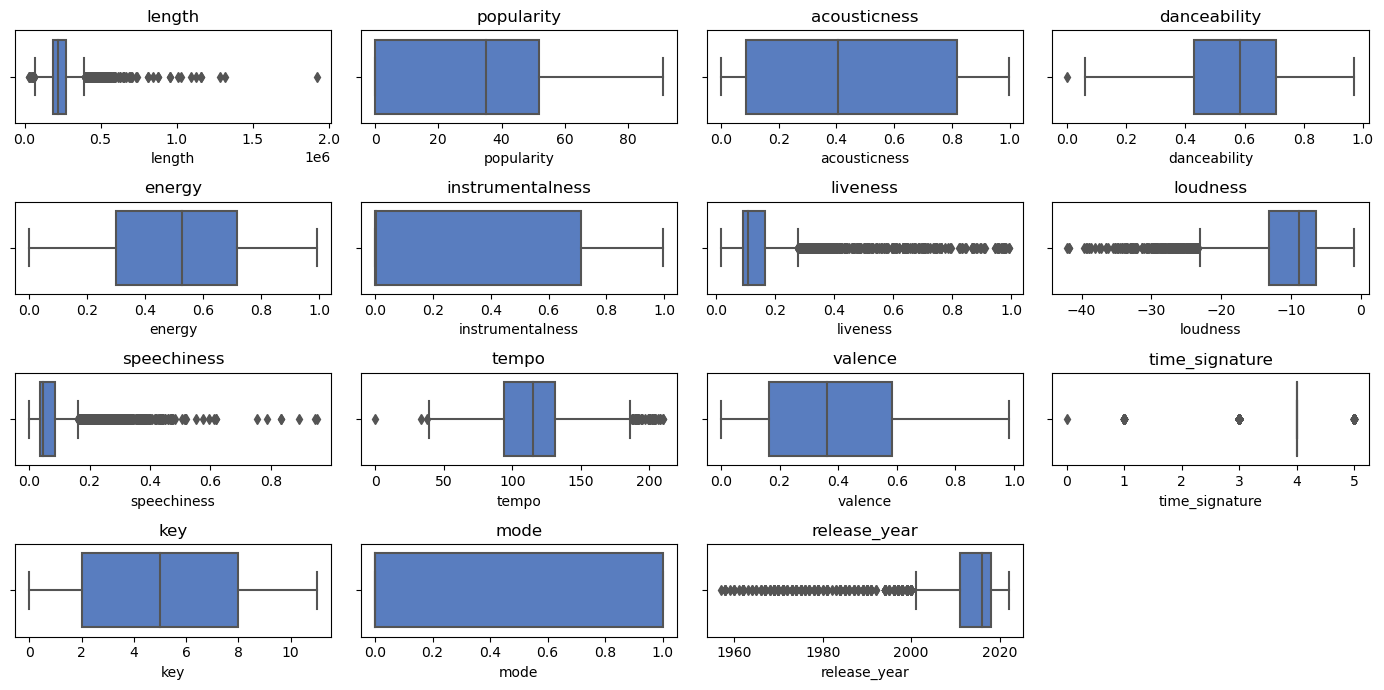

In [170]:
# Plot boxplot to understand distribution

plt.figure(figsize=(14, 7)) # size of an individual graph

# Loop through each numeric column and create a boxplot
for i, column in enumerate(df.select_dtypes(include='number').columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x = df[column], palette='muted')
    plt.title(column) # Add column name

plt.tight_layout()
plt.show()

**Observation**:

Based on the first exploratory analysis:

- **`Length`**: Average duration of a song is 4 minutes. Most songs range from 3 to 5 minutes with some extreme outliers *(30 min songs, classical music?)*.
- **`Popularity`**: Fixed scale from 0 to 100. Most song have low popularity *(mean=32)*. However some tracks are very popular.
- **`Acousticness`**: Moderate on average *(mean = 0.45)*.
- **`Danceability`**: Moderate on average *(mean = 0.56)*, but there's significant variation.
- **`Energy`**: Energy levels are balanced, with most songs being moderately energetic *(mean = 0.50)*.
- **`Instrumentalness`**: The majority of songs are not instrumental *(mean =0.28)*.
- **`Liveness`**: Most songs have low liveness score *(mean = 0.16)*, though some outlier exist *(>0.3)*.
- **`Loudness`**: The typical loudness is around -10.7 dB, with some songs being much louder or quieter.
- **` Speechiness`**: Most songs have little spoken word content, *(mean = 0.085)* with some outlier *(rap music?)*.
- **`Tempo`**: The average tempo is 115 BPM, with some tracks having much slower or faster tempos.
- **`Valence`**: General mood is neutral to somewhat negative *(mean = 0.39)*, although some tracks are very positive.
- **`Time Signature`**: The majority of songs follow 4/4 time signature
- **`Key`**: The songs tend to be in mid-range keys *(mean = 5.3)*, with a mix of both major and minor tonalities.
- **`Mode`**: There are slightly more tracks in minor keys *(mean = 0.46)*.
- **`Release Year`**: Most songs were released after 2010, with the oldest song dating back to 1957.


**To summarize**, songs have distinct features that set them apart. Further analysis is needed to explore potential correlations between features and identify patterns that may vary between the `top_year` and `user` groups.

### 1.7 Correlation Analysis

In [186]:
# Calculate correlation matrix
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap = 'coolwarm').format(precision=3)

,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year
length,1.000,-0.092,0.030,-0.119,-0.050,0.152,-0.006,-0.085,-0.021,-0.021,-0.188,-0.019,-0.030,0.031,-0.142
popularity,-0.092,1.000,-0.039,0.053,0.059,-0.138,-0.055,0.102,0.041,0.032,0.033,-0.017,0.003,-0.008,0.027
acousticness,0.030,-0.039,1.000,-0.438,-0.786,0.247,-0.110,-0.677,-0.180,-0.162,-0.318,-0.233,-0.044,-0.005,-0.169
danceability,-0.119,0.053,-0.438,1.000,0.483,-0.375,0.017,0.529,0.254,0.103,0.584,0.255,0.030,-0.019,0.140
energy,-0.050,0.059,-0.786,0.483,1.000,-0.308,0.152,0.828,0.252,0.182,0.478,0.240,0.056,-0.033,0.181
instrumentalness,0.152,-0.138,0.247,-0.375,-0.308,1.000,-0.099,-0.481,-0.256,-0.056,-0.412,-0.134,-0.002,0.001,-0.010
liveness,-0.006,-0.055,-0.110,0.017,0.152,-0.099,1.000,0.089,0.102,0.028,0.120,-0.014,0.009,0.015,-0.038
loudness,-0.085,0.102,-0.677,0.529,0.828,-0.481,0.089,1.000,0.202,0.163,0.464,0.241,0.039,-0.013,0.218
speechiness,-0.021,0.041,-0.180,0.254,0.252,-0.256,0.102,0.202,1.000,0.031,0.250,0.069,0.014,-0.034,0.101
tempo,-0.021,0.032,-0.162,0.103,0.182,-0.056,0.028,0.163,0.031,1.000,0.097,0.011,0.010,-0.057,0.025


**Analysis**: We are checking for multicollinearity

Based on https://developer.spotify.com/documentation/web-api/reference/get-audio-features

- `loudness` and `energy` are highly correlated (0.828). There may be multicollinearity bias here
- `acousticness` is strongly negatively correlated with `loudness` (-0.677) and `energy` (-0.786)
- `danceability` and `valence` are positively correlated (0.584)

`loudness`, `energy`, `danceability` and `valence` seems to all be correlated together to some extend.  
We should keep that in mind during the next step.

**Action**: Also, removing either `loudness` or `energy` should be done to avoid multicollinearity bias.

### 1.8 Feature-Target Relationship Analysis (User)

We are checking how each feature is related with the target variable. We start first with `User`.
- Plot the continuous value against the target `user` and also get the related histogram
- Get contingency table for `time_signature` and `mode` since they are categorical feature

In [212]:
# Store numeric columns
numerical_cols = ['length', 'popularity',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

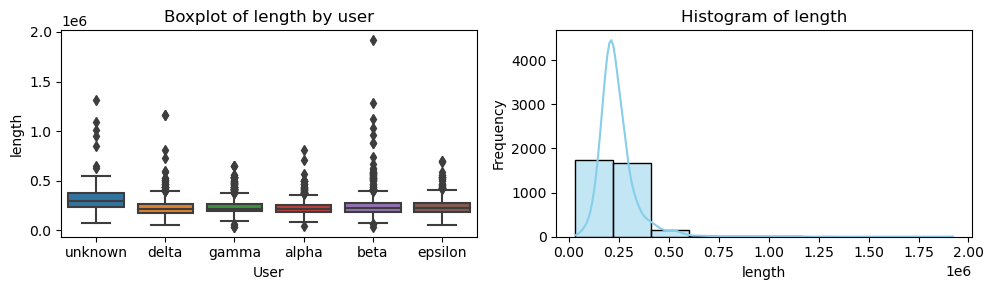

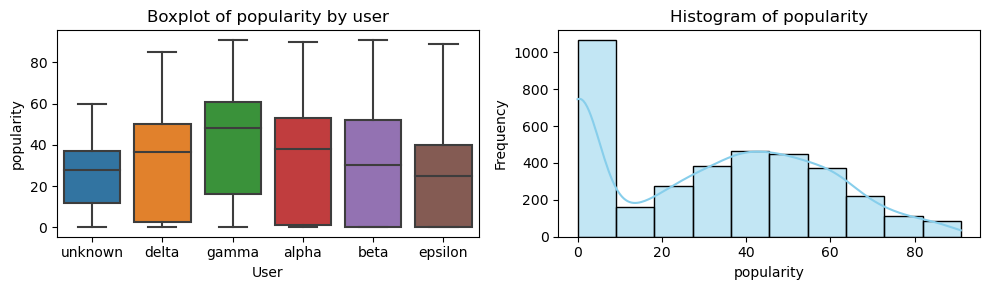

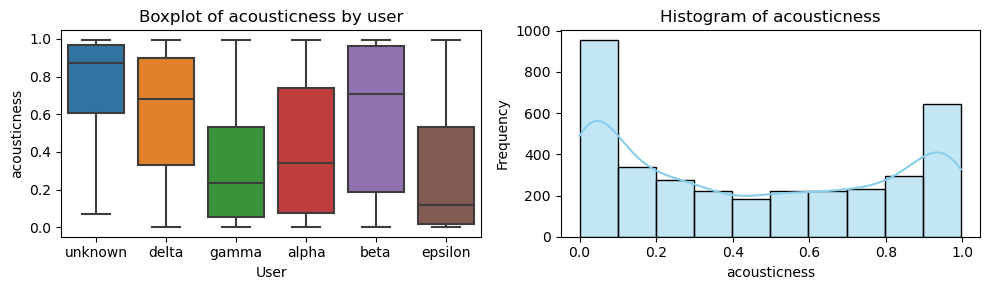

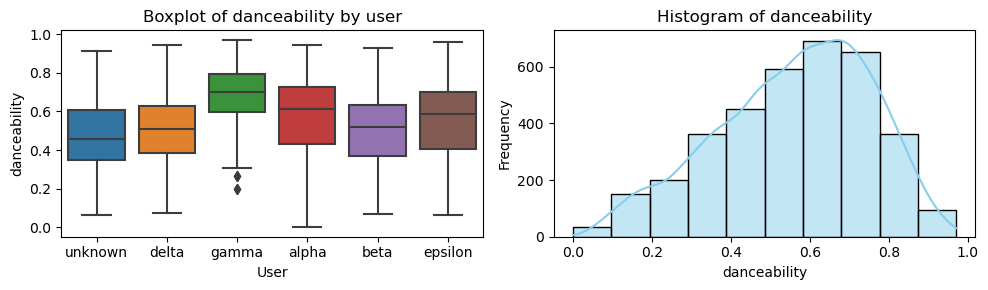

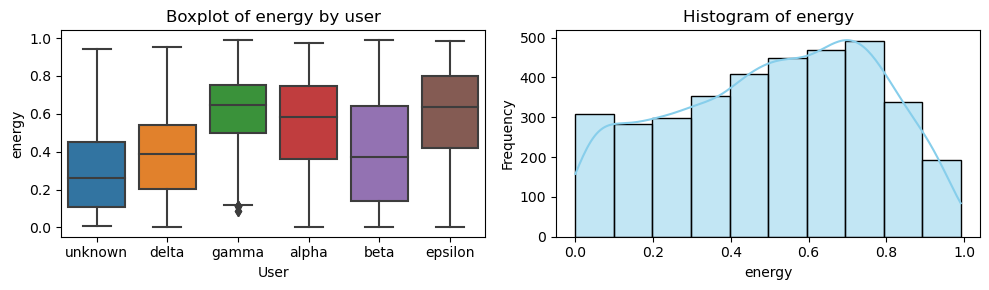

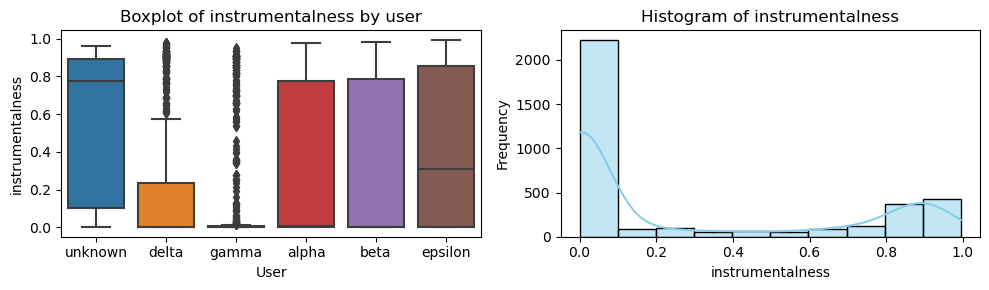

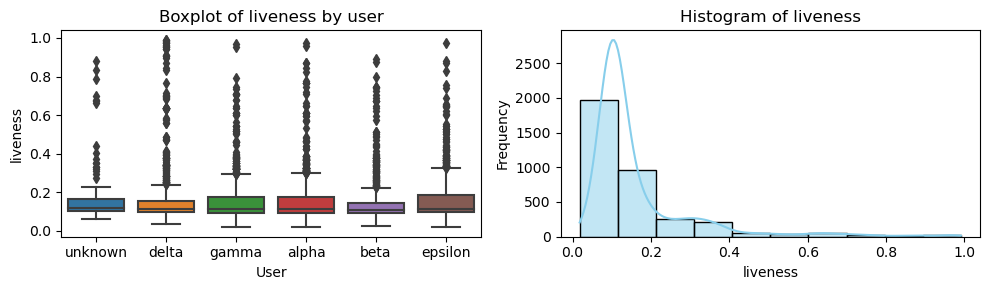

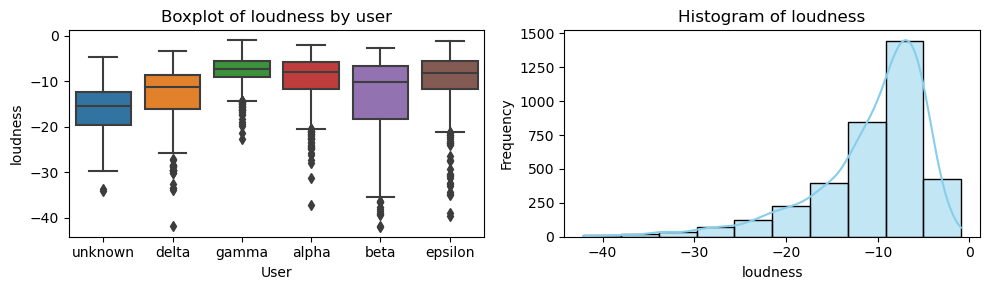

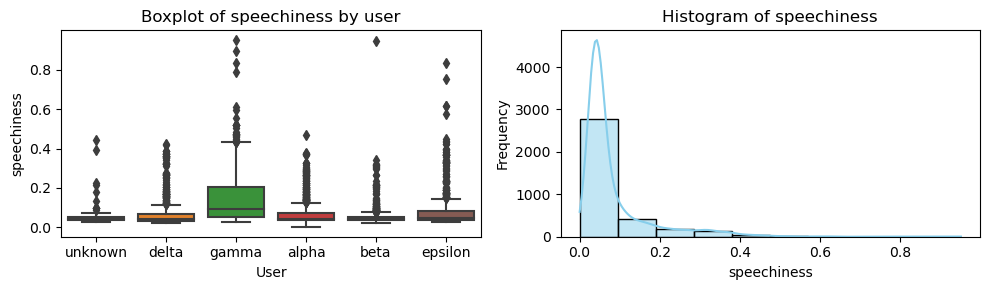

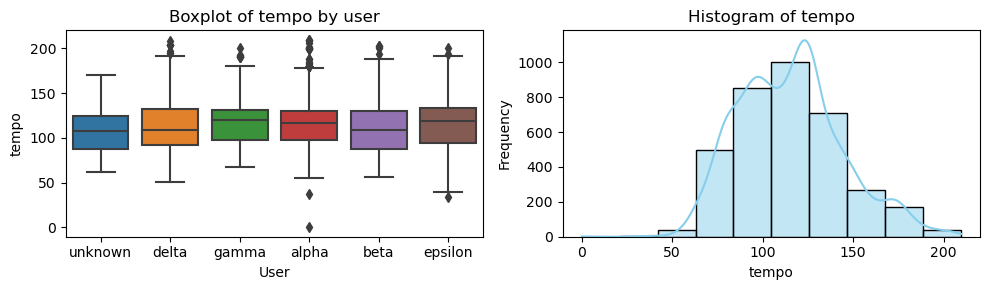

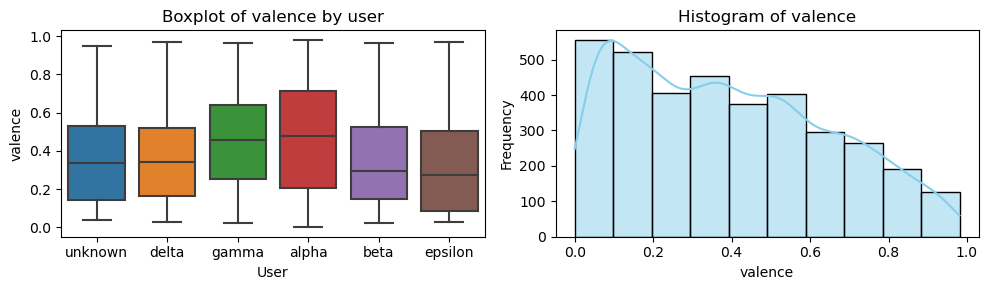

In [217]:
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    
    # Boxplot
    sns.boxplot(x='user', y=col, data=df, ax=axes[0])
    axes[0].set_title(f'Boxplot of {col} by user')
    axes[0].set_xlabel('User')
    axes[0].set_ylabel(col)
    
    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[1], bins=10, color='skyblue')
    axes[1].set_title(f'Histogram of {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    display(fig)  # Ensures the current figure is displayed in the notebook
    plt.close(fig)  # Closes the figure to avoid overlapping issues

In [210]:
# Contingency table for `time_signature`
pd.crosstab(df['user'], df['time_signature'] )

time_signature,0,1,3,4,5
user,,,,,
alpha,1,6,90,597,6
beta,0,14,84,590,12
delta,0,6,132,544,14
epsilon,0,8,47,628,12
gamma,0,3,50,625,20
unknown,0,3,20,72,5


In [211]:
# Contingency table for `mode`
pd.crosstab(df['user'], df['mode'] )

mode,0,1
user,,
alpha,390,310
beta,279,421
delta,414,282
epsilon,415,280
gamma,370,328
unknown,57,43


**Observation**:

Reminder: `unknown` is not a separate group but a missing value from one of the 5 users.

- **`gamma`**: Most distinct taste in music. Prefers **energetic**, **danceable**, and **loud** tracks. Also, likes **low instrumentalness**, **high speechiness**, and popular songs. *(Pop/Electronic/House?)*
- **`epsilon`**: Similar to `gamma`, but with **lower valence**, **lower speechiness**, **higher instrumentalness**, and prefers **less-known artists**. *(Experimental/Indie?)*
- **`alpha`**: Notable for **lower acousticness**, **higher energy**, and **higher valence** compared to `beta` and `delta`.
- **`beta`**: Notable for **outliers in song duration**, **wide spread in acousticness** and **energy**, and listens mainly to **mode = 0** songs. *(Tendency for melancholic sound?)*
- **`delta`**: Has **low instrumentalness** compared to `alpha` and `beta`.

Overall, **gamma** is the most distinct, followed by **epsilon**. **Alpha**, **beta**, and **delta** are similar, with **beta** standing out due to some unique characteristics.


### 1.9 Feature-Target Relationship Analysis (Top_Year)

We are checking how each feature is related with the target variable `Top_Year`
- Plot the continuous value against the target `user` and also get the related histogram
- Get contingency table for `time_signature` and `mode` since they are categorical feature

`Top_Year` is defined as the top of the year song for that particular user.

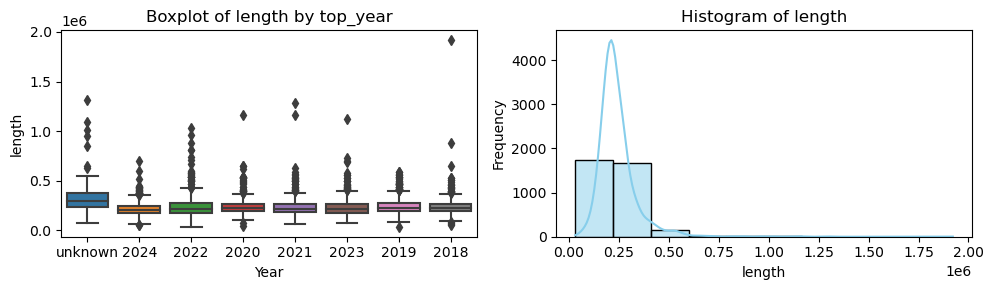

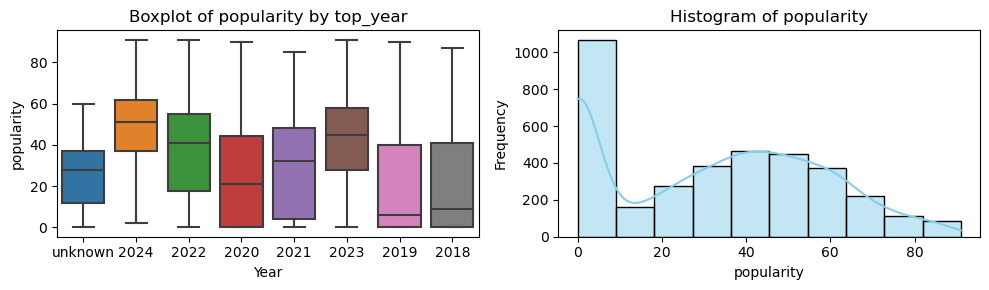

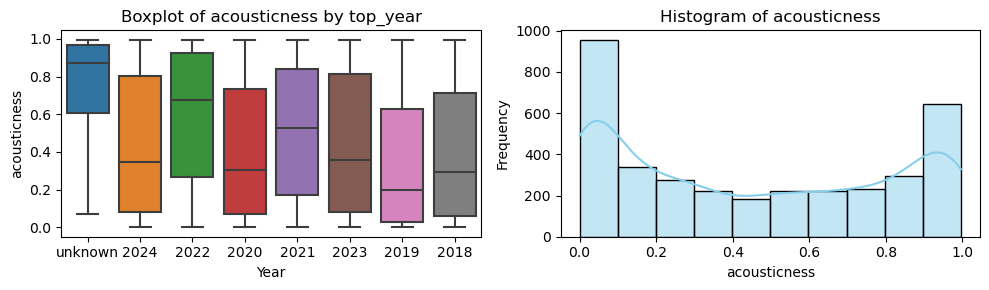

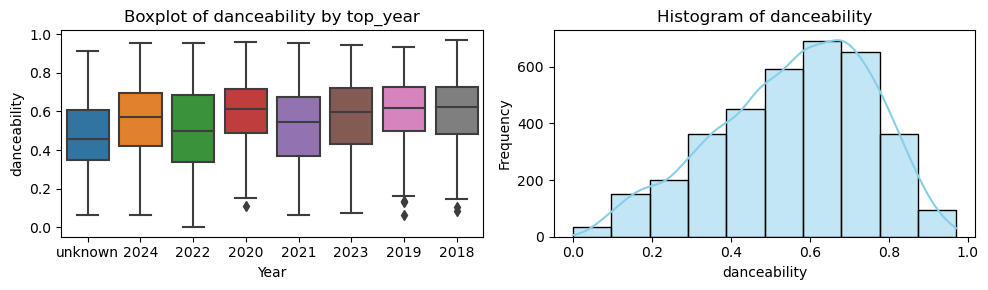

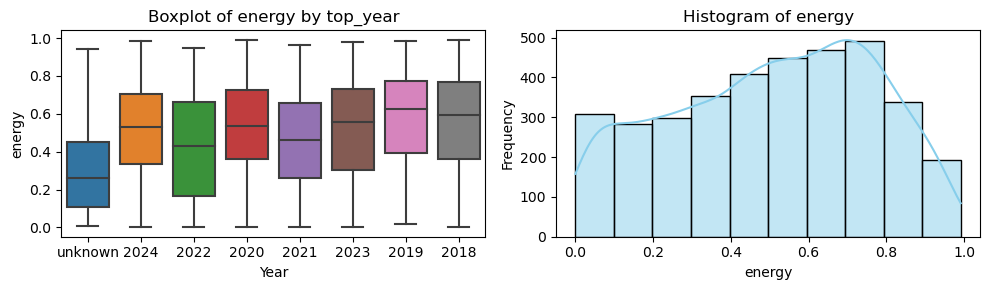

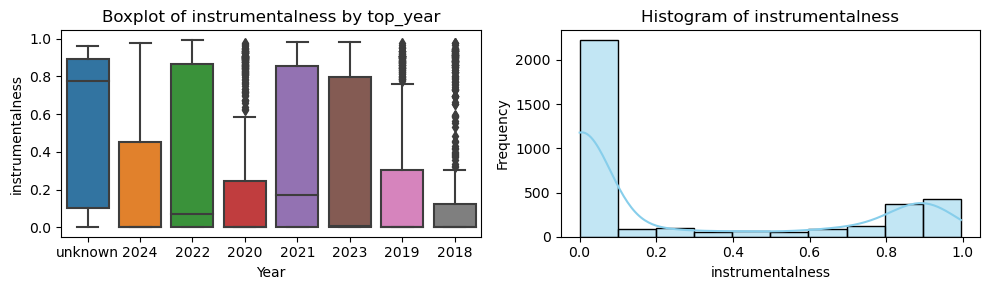

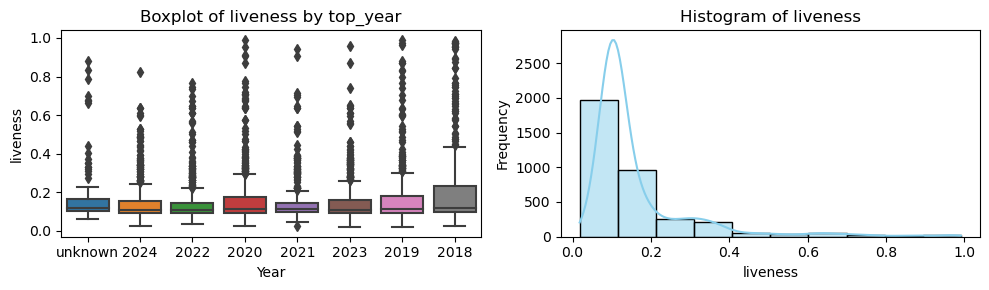

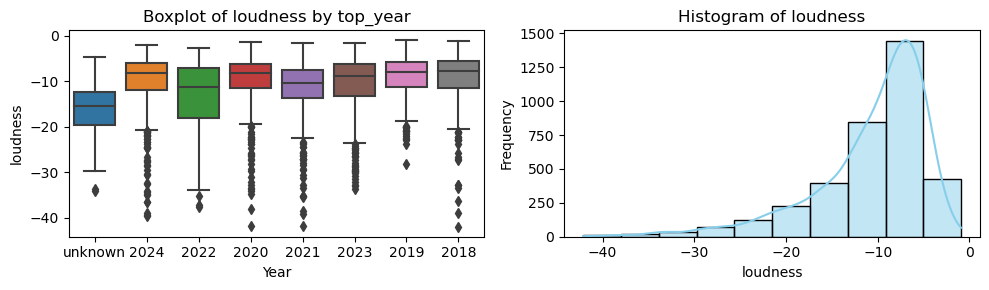

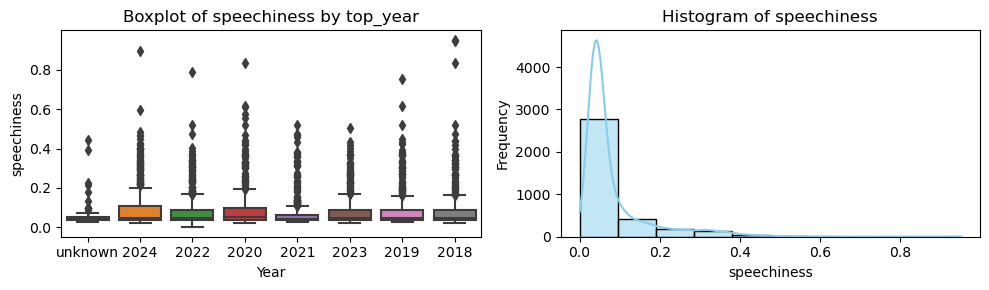

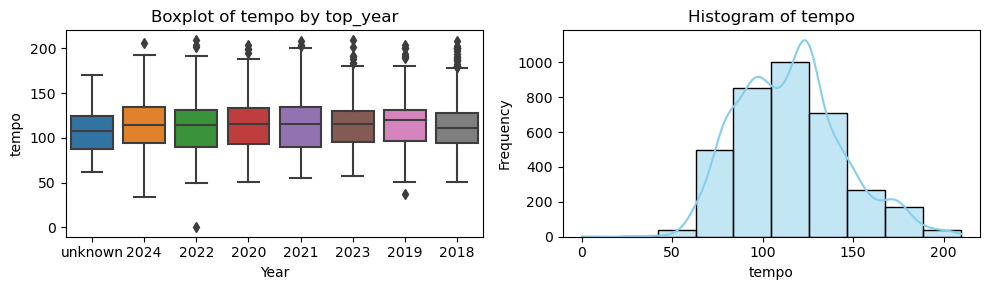

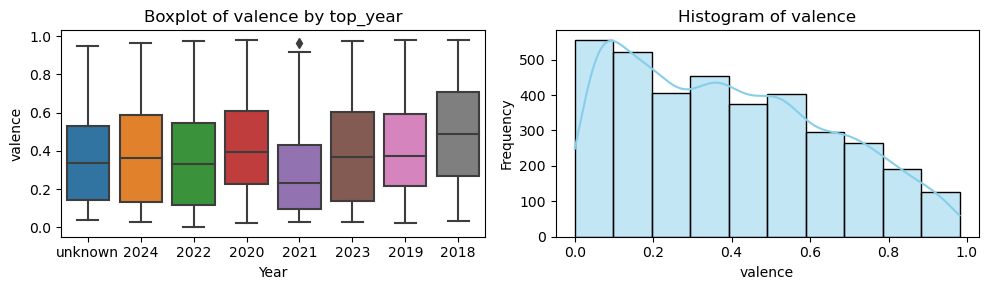

In [224]:
for col in numerical_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    
    # Boxplot
    sns.boxplot(x='top_year', y=col, data=df, ax=axes[0])
    axes[0].set_title(f'Boxplot of {col} by top_year')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel(col)
    
    # Histogram
    sns.histplot(df[col], kde=True, ax=axes[1], bins=10, color='skyblue')
    axes[1].set_title(f'Histogram of {col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    display(fig)  # Ensures the current figure is displayed in the notebook
    plt.close(fig)  # Closes the figure to avoid overlapping issues

In [219]:
# Contingency table for `time_signature`
pd.crosstab(df['top_year'], df['time_signature'] )

time_signature,0,1,3,4,5
top_year,,,,,
2018,0,4,39,453,4
2019,0,5,42,447,4
2020,0,2,48,434,11
2021,0,7,70,402,17
2022,1,11,91,384,13
2023,0,6,56,432,6
2024,0,2,57,432,9
unknown,0,3,20,72,5


In [221]:
# Contingency table for `top_year`
pd.crosstab(df['top_year'], df['mode'] )

mode,0,1
top_year,,
2018,246,254
2019,256,242
2020,252,243
2021,243,253
2022,282,218
2023,303,197
2024,286,214
unknown,57,43


**Observation**

- Since it combines user tastes, the top songs of the year become somewhat irrelevant. There are noticeable differences, but nothing truly distinguishable based on song features.
- It might be better to split the analysis by user and top year, or explore metadata like artist or group instead.


##  DATA PREPARATION
[Go back to summary](#SUMMARY)  

In [443]:
# Load the copy to make sure
df = df_copy.copy()

Step implemented:
- remove duplicate (2 rows)
- Drop missing values (9 rows)
- Convert `time_signature` and `mode` to categorical value
- Convert time from millisecond to second
- Perform scaling of data (Z-score normalization)

About data standardization:
- **Transform the data** to have a mean = 0 and std = 1 to ensure numeric feature have the same scal
- **Improve model convergence** (Gradient descent for Logistic Regression)
- **Equal weight for feature**: avoid bias introduced by different scale (here millisecond) compare to song feature (ranging from 0 to 1)
- **Distanced-base algorithm**: avoid biasing kNN algorithm

In [444]:
# Preprocessing the dataset
def preprocess_data(df):
    # Remove duplicates
    df.drop_duplicates(inplace=True)

    #Remove missing value row
    df.dropna(subset=['name'], inplace=True)

    # Convert columns to appropriate data types
    df['time_signature'] = df['time_signature'].astype('category')
    df['mode'] = df['mode'].astype('category')

    #Convert time from milliseconds to seconds (for better interrpetability)
    df['length'] = (df['length'] / 1000).round(0)

    # Scale numerical features
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df

In [445]:
# Apply data preparation step
df = preprocess_data(df)
# Check
df.head(4)

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
0,"Variations on a Polish Theme, Op. 10: No. 5 Andantino","Szymanowski: Piano Works, Vol. 2",Karol Szymanowski,06/12/1996,-1.594146,0.814694,1.520930,-1.187067,-1.912687,1.553686,-0.519710,-3.729249,-0.430687,-1.554464,-0.593260,4,1.624840,0,spotify:track:3bcdLMrAxrfn5dxInjIdI2,-1.533097,unknown,unknown
1,Je vous trouve un charme fou - En duo avec Gaëtan Roussel,Il suffit d'y croire (Version deluxe),Hoshi,2018-11-30,-0.663866,1.168343,0.476918,0.286939,0.364941,-0.725881,0.196248,0.315673,1.795288,-0.975575,0.918189,4,-1.226635,1,spotify:track:0C2yaSWVgCUiiqPyYxSOkd,0.527018,2024,delta
2,Me Gusta,On ira où ?,DTF,2019-10-11,-0.644485,1.561287,-0.106500,1.415636,0.884288,-0.725796,-0.361549,0.754380,2.736142,-0.871014,-0.133593,4,0.199103,0,spotify:track:6P3FBaZfUjeWYExU2ShaPZ,0.620659,2022,gamma
3,L’amour en Solitaire,Petite Amie (Deluxe),Juliette Armanet,2018-02-02,-0.644485,-1.267910,-0.131624,1.224943,0.007168,-0.725498,0.641073,0.623418,-0.560054,0.449036,0.579281,4,-0.086045,0,spotify:track:2tn51grfchxArwPXeXkoX5,0.527018,2020,gamma


##  MODEL-USER
[Go back to summary](#SUMMARY)

### 3.1 Feature Engineering

## 🚨 Important Note 🚨

This is **not** a standard supervised learning problem where we predict an unknown future user.

Instead, we're **recovering missing user data** that originally existed but was later deleted.  
The goal is to **restore** this information using past listening patterns that were present before deletion.

Because of this, using **target-related features** (like how many times a user has listened to an artist) is **<span style="color:red;">not data leakage in this specific case</span>**—it's leveraging information that was already there.

In a **classic prediction setup**, we **<span style="color:red;">would never</span>** use these metrics to predict future users.  
But here, they help **reconstruct lost data**, making them **valid for our task**.


**The added feature here:**  
Number of time a user has listened to an artist in the past  
This feature capture the **user’s past behavior toward certain artists** (and songs), which was lost due to data deletion.

In [446]:
# Create a count of previous artist listened by song for each user

def feature_engineering_user(df):
    # Step 1: Preserve the original index as a column
    df['original_index'] = df.index

    # Step 2: Create the count matrix for 'user' prediction
    count_matrix = df.groupby(['artist', 'user']).size().unstack(fill_value=0)
    count_matrix = count_matrix.drop(columns=['unknown'], errors='ignore')

    # Step 3: Merge the count matrix back to the original DataFrame
    df = df.merge(count_matrix, on='artist', how='left', suffixes=('', '_artist_count'))

    # Step 4: Restore the original index
    df.set_index('original_index', inplace=True)

    return df

# Apply the feature engineering
df = feature_engineering_user(df)

### 3.2 Data preparation
Mainly separating target and label and dealing with column

In [447]:
# Prepare features and labels for user prediction
def clean_features(df):
    columns_to_drop = ['name', 'album', 'artist', 'release_date', 'uri', 'energy'] # Remove energy to avoid multicollinearity
    df = df.drop(columns=columns_to_drop, errors='ignore')
    categorical_cols = df.select_dtypes(include=['category', 'object']).columns
    
    for col in categorical_cols:
        df[col] = pd.Categorical(df[col]).codes

    return df

In [448]:
# Separate known and unknown users
user_known = df[df['user'] != 'unknown']
user_unknown = df[df['user'] == 'unknown']

# Create the train dataset
X_user = clean_features(user_known.drop(columns=['user', 'top_year'])) # drop target variables
# Assign target
y_user = user_known['user']

In [449]:
# Dealing with categorical data
label_encoder_user = LabelEncoder()
y_user_encoded = label_encoder_user.fit_transform(y_user)

We split the data between Training and Test dataset.  
We did not use a validation set for few reasons that are open to discuss:
- **No need for generalization**
- **Small dataset**: Given the limited data (3600 rows), splitting further may hurt the model performance
- **Learning over performance**: The goal was to learn the process, not optimize for the best solution.
- **Lack of knowledge:** As students, we didn’t yet apply a validation set in our approach.

Drawback:
- **Prone to overfitting**: without a validation set, it is harder to detect overfitting
- **No hyper-parameter tuning**: alidation sets are typically used for hyperparameter tuning leading to better model
- **Limited model insight**: A validation set helps track training progress and enables early stopping to prevent overfitting.

In [450]:
# Split between train and test
X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
    X_user, y_user_encoded, train_size=0.7, random_state=1
)

### 3.3 Logistic Regression

Logistic Regression is chosen here because it's a simple, effective model for multi-classification.  
It works well for predicting categories and is easy to interpret

Keypoint:
- **Simple and effective model**: for multi-classification case
- **Better interpretability**: by recovering the coefficient
- **L2 regularization**: Initially, the model over-relied on the new feature. To balance the influence of past behavior and song features, I introduced L2 regularization to shrink coefficients and allow for more balanced feature contribution.

In [451]:
# Logistic regression pipeline for user prediction
user_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=1)),
    ('scaler', StandardScaler()),
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter= 1000 , penalty='l2'))) # Penalty for over-relying on a specific feature
])

# Fit the model
user_pipeline.fit(X_train_user, y_train_user)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [452]:
# Prediction on User train set
y_train_pred_user = user_pipeline.predict(X_train_user)

### 3.4 Evaluate the performance

In [453]:
# Prediction on the train data
print("Training Data Classification Report:")
print(classification_report(y_train_user, y_train_pred_user))

Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       476
           1       0.85      0.86      0.85       483
           2       0.87      0.86      0.86       478
           3       0.89      0.93      0.91       507
           4       0.91      0.92      0.91       498

    accuracy                           0.87      2442
   macro avg       0.87      0.87      0.87      2442
weighted avg       0.87      0.87      0.87      2442



### Training Data Classification Report:

The model performs well with an overall accuracy of **87%**. Here are the key metrics:

- **Precision**: 0.85-0.91 across classes.
- **Recall**: 0.79_0.93, with class 3 having the highest recall (0.93).
- **F1-Score**: 0.82-0.91, showing a good balance.
- **Macro & Weighted Averages**: Both around 0.87, indicating consistent performance.


In [454]:
# Prediction on the test data
y_test_pred_user = user_pipeline.predict(X_test_user)

print("Test Data Classification Report:")
print(classification_report(y_test_user, y_test_pred_user))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       224
           1       0.89      0.86      0.87       217
           2       0.87      0.86      0.86       218
           3       0.83      0.95      0.89       188
           4       0.90      0.89      0.89       200

    accuracy                           0.87      1047
   macro avg       0.87      0.87      0.87      1047
weighted avg       0.87      0.87      0.87      1047



### Test Data Classification Report:

The model performs similarly well on the test set with an accuracy of **87%**. Key metrics are as follows:

- **Precision**: 0.83-0.90 across classes.
- **Recall**: 0.78-0.95, with class 3 having the highest recall (0.95).
- **F1-Score**: 0.82-0.89, indicating good balance.
- **Macro & Weighted Averages**: Both around 0.87, showing consistent performance across all classes.

Overall, the model did generalize quite well and is effective at **recovering** the missing user

### 3.5 Interpretability

We extract the model coefficients to identify the most impactful features.  
As mentioned earlier, L2 penalty was applied to prevent overreliance on the newly created features and allow for a better balance with existing data.

In [455]:
# Get the feature names after PolynomialFeatures transformation
poly_transformer = user_pipeline.named_steps['poly']
feature_names = poly_transformer.get_feature_names_out(X_user.columns)

# Add 'intercept' to the feature names
col_coef_df = ['intercept'] + list(feature_names)

# Access the OneVsRestClassifier inside the pipeline
ovr_classifier = user_pipeline.named_steps['classifier']

# Initialize an empty DataFrame to store coefficients
coef_df = pd.DataFrame(columns=col_coef_df)

# Iterate over each logistic regression model in OneVsRestClassifier
for i, estimator in enumerate(ovr_classifier.estimators_):
    # Combine intercept and coefficients
    intercept_and_coef = [estimator.intercept_[0]] + estimator.coef_.flatten().tolist()
    row = pd.Series(intercept_and_coef, index=col_coef_df)
    
    # Append the row to the DataFrame
    coef_df = pd.concat([coef_df, row.to_frame().T], ignore_index=True)

In [456]:
# Display the coefficients DataFrame
pd.set_option('display.max_columns', None)  # No limit on columns
coef_df

,intercept,1,length,popularity,acousticness,danceability,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,release_year,alpha,beta,delta,epsilon,gamma
0,-2.326080,0.0,0.017825,0.178422,-0.057884,-0.139130,0.276361,0.031776,0.019353,-0.061624,-0.073768,0.460503,-0.059257,-0.209634,-0.054195,0.009297,3.593210,-0.952516,-1.373505,-1.338615,-2.272582
1,-3.328219,0.0,0.144096,-0.123597,0.310103,-0.202903,-0.686798,-0.132983,-0.532335,-0.518969,0.033733,0.183406,0.124217,0.134725,0.426631,0.081367,-0.664133,2.001571,-3.966839,-0.683531,-0.826687
2,-2.013668,0.0,-0.153045,-0.051944,0.415223,-0.049618,-0.421776,0.034577,-0.171955,-0.260469,0.045557,-0.098376,0.012364,-0.014058,-0.135649,-0.326588,-1.745097,-1.395176,5.213645,-0.890202,-1.494953
3,-4.154240,0.0,-0.163426,-0.238793,-0.411020,-0.176140,0.387888,0.090226,0.425217,0.182506,0.006468,-0.167992,0.102740,0.126372,-0.153452,0.398615,-4.089585,-3.550788,-3.313403,7.836781,-2.507520
4,-2.070468,0.0,0.226194,0.216133,-0.073415,0.556250,-0.056953,-0.112513,0.485042,0.111461,0.078832,-0.195338,-0.107733,-0.086649,0.106091,0.029783,-1.585514,-1.715078,-0.038873,-0.492014,4.935589


By examining the coefficients, we can observe the following:
- **Previous artist count**: This is the main predictor.
- **Song features**: The model incorporates song characteristics as requested (and introduced by Ridge regularization
- **Song feature variation**: The coefficients for song features differ between users, highlighting patterns identified during EDA.

## MODEL-TOP-YEAR
[Go back to summary](#SUMMARY)

### 4.1 Feature engineering

## 🚨 Important Note 🚨

This is **not** a standard supervised learning problem where we predict an unknown future user.

Instead, we're **recovering missing user data** that originally existed but was later deleted.  
The goal is to **restore** this information using past listening patterns that were present before deletion.

Because of this, using **target-related features** (like to which year the song belong to based on its album release date) is **<span style="color:red;">not data leakage in this specific case</span>**—it's leveraging information that was already there.

In a **classic prediction setup**, we **<span style="color:red;">would never</span>** use these metrics to predict future users.  
But here, they help **reconstruct lost data**, making them **valid for our task**.


**The added feature here:**  
The number of times a song has appeared in a given year, based on its album's appearance in the top year.  
The idea is that if an album was popular in a specific year, the tracks from it are likely to be liked as well.  
This feature capture the **trends in how an album** (and its song) is popular over the year, data that was lost due to data deletion.

In [457]:
# Create a feature that input the top year of a song based on its album
def feature_engineering_year(df):
    # Step 1: Preserve the original index as a column
    df['original_index'] = df.index

    # Step 2: Create the count matrix for 'top_year' prediction
    count_matrix = df.groupby(['album', 'top_year']).size().unstack(fill_value=0)
    count_matrix = count_matrix.drop(columns=['unknown'], errors='ignore')

    # Step 3: Merge the count matrix back to the original DataFrame
    df = df.merge(count_matrix, on='album', how='left', suffixes=('', '_album_count'))

    # Step 4: Restore the original index
    df.set_index('original_index', inplace=True)

    return df

### 4.2 Data Preparation
Mainly separating target and label and dealing with column

In [458]:
df = feature_engineering_year(df)
# Separate known and unknown top_year
year_known = df[df['top_year'] != 'unknown']
year_unknown = df[df['top_year'] == 'unknown']

In [459]:
# Prepare train dataset
X_year = clean_features(year_known.drop(columns=['user', 'top_year'])) # Drop target on train dataset
y_year = year_known['top_year']

In [460]:
# Dealing with categorical data
label_encoder_year = LabelEncoder()
y_year_encoded = label_encoder_year.fit_transform(y_year)

In [461]:
# Split between train and test
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
    X_year, y_year_encoded, test_size=0.3, random_state=1
)

### 4.3 kNN - *(1st model)*
We tried K-Nearest Neighbor (kNN) clustering with k = 7, based on the knowledge that there are 7 different classes to predict.  
We also performed hyperparameter optimization to find the most accurate model for predicting the year.

In [462]:
# KNN pipeline for top_year prediction
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
param_grid = {
    'knn__n_neighbors': [7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
grid_search_year = GridSearchCV(knn_pipeline, param_grid, cv=10, scoring='accuracy')
grid_search_year.fit(X_train_year, y_train_year)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [7],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [463]:
# Best parameter founded, k = 7 match the knowledge of our data (7 class to predict from 2018 to 2024)
# df['top_year'].unique() => ['2024', '2022', '2020', '2021', '2023', '2019', '2018']
print("Best Parameters:", grid_search_year.best_params_)

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}


In [464]:
# Prediction on Top Year train set
y_train_pred_year = grid_search_year.predict(X_train_year)

### 4.3.1 Evaluate the performance

In [465]:
# Evaluate on the train dataset
print("Training Data Classification Report:")
print(classification_report(y_train_year, y_train_pred_year))

Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       337
           1       0.78      0.81      0.79       348
           2       0.78      0.79      0.79       347
           3       0.75      0.81      0.78       343
           4       0.75      0.68      0.71       370
           5       0.72      0.70      0.71       348
           6       0.83      0.75      0.79       349

    accuracy                           0.77      2442
   macro avg       0.77      0.77      0.77      2442
weighted avg       0.77      0.77      0.77      2442



### Training Data Classification Report:

The model achieves an **accuracy of 77%** on the training set. Key metrics:

- **Precision**: Ranges from 0.72 to 0.83 across classes.
- **Recall**: Ranges from 0.68 to 0.88, with class 0 having the highest recall (0.88).
- **F1-Score**: Ranges from 0.71 to 0.83, indicating good performance.
- **Macro & Weighted Averages**: Both around 0.77, showing consistent performance across all classes.

In [466]:
# Prediction on Top Year test data
y_test_pred_year = grid_search_year.predict(X_test_year)

# Evalaute on test dataset
print("Test Data Classification Report:")
print(classification_report(y_test_year, y_test_pred_year))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       163
           1       0.71      0.72      0.72       150
           2       0.66      0.70      0.68       148
           3       0.65      0.66      0.66       153
           4       0.52      0.55      0.53       130
           5       0.57      0.49      0.53       152
           6       0.71      0.62      0.66       151

    accuracy                           0.66      1047
   macro avg       0.65      0.65      0.65      1047
weighted avg       0.66      0.66      0.66      1047



### Test Data Classification Report:

The model achieves an **accuracy of 66%** on the test set. Key metrics:

- **Precision**: Ranges from 0.52 to 0.75 across classes.
- **Recall**: Ranges from 0.49 to 0.83, with class 0 having the highest recall (0.83).
- **F1-Score**: Ranges from 0.53 to 0.79, indicating a moderate performance.
- **Macro & Weighted Averages**: Both around 0.65, showing a slight drop in performance compared to the training data.

**Conclusion**: The model did not generalize well, we will try another model

### 4.4 Decision Tree  *(2nd model)*
We will compare the performance of a Decision Tree against kNN.  
While Decision Trees are inherently prone to overfitting, we can mitigate this by controlling their complexity and applying pruning techniques.  
This way, we can ensure that the model generalizes well and performs effectively on the unseen top-year data

**Note**: Data standardization was done but it is not necessary for Decision tree

In [467]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.tree import plot_tree

### 4.4.1 Hyperparameter tuning and fitting the Decision Tree

In [468]:
# Grid search: Define the hyper-parameters to search
param_distributions = dict(
    criterion = ['gini', 'entropy'],
    max_depth = randint(low = 10, high = 50),
    min_samples_split = randint(low = 2, high = 30),
    min_samples_leaf = randint(low = 1, high = 30),
    max_features = ['sqrt', 'log2', None],
    min_impurity_decrease = uniform(0, 0.01)
)

# Hyper-parameter tuning through random search cross-validation
rand_clf = RandomizedSearchCV(
    estimator = DecisionTreeClassifier(),
    param_distributions = param_distributions,
    n_iter = 20,  # Number of parameter settings that are sampled
    scoring = 'accuracy',  # Use F1 weighted score for evaluation
    refit = True,  # Refitting the best model after searching
    cv = 10,  # 3-fold cross-validation
    verbose = 10,  # Verbosity level
    random_state = 0,  # For reproducibility
)
rand_clf.fit(X_train_year, y_train_year)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV 1/10; 1/20] START criterion=gini, max_depth=10, max_features=log2, min_impurity_decrease=0.006235636967859724, min_samples_leaf=19, min_samples_split=6
[CV 1/10; 1/20] END criterion=gini, max_depth=10, max_features=log2, min_impurity_decrease=0.006235636967859724, min_samples_leaf=19, min_samples_split=6;, score=0.596 total time=   0.0s
[CV 2/10; 1/20] START criterion=gini, max_depth=10, max_features=log2, min_impurity_decrease=0.006235636967859724, min_samples_leaf=19, min_samples_split=6
[CV 2/10; 1/20] END criterion=gini, max_depth=10, max_features=log2, min_impurity_decrease=0.006235636967859724, min_samples_leaf=19, min_samples_split=6;, score=0.445 total time=   0.0s
[CV 3/10; 1/20] START criterion=gini, max_depth=10, max_features=log2, min_impurity_decrease=0.006235636967859724, min_samples_leaf=19, min_samples_split=6
[CV 3/10; 1/20] END criterion=gini, max_depth=10, max_features=log2, min_impurity_decrease=0.00

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=20,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A3E86ACD90>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002A3ED22B5D0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A3EE0417D0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002A3FBFF4F50>},
                   random_state=0, scoring='accuracy', verbose=10)

In [469]:
# Output the best parameters and score
print("Best Parameters:", rand_clf.best_params_)
print("Best Score:", rand_clf.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 46, 'max_features': None, 'min_impurity_decrease': 0.009719450024996659, 'min_samples_leaf': 4, 'min_samples_split': 4}
Best Score: 0.7780595516895283


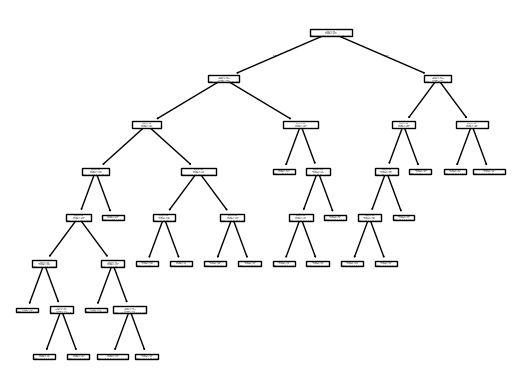

In [470]:
# Retrieve the best estimator
plt.figure()
plot_tree(rand_clf.best_estimator_)
plt.show()

### 4.4.2 Evaluation

In [471]:
# Prediction on Top Year train set
y_train_pred_year = rand_clf.predict(X_train_year)

print("Training Data Classification Report:")
print(classification_report(y_train_year, y_train_pred_year))

Training Data Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       337
           1       0.68      0.94      0.79       348
           2       0.80      0.73      0.77       347
           3       0.87      0.80      0.84       343
           4       0.73      0.81      0.77       370
           5       0.75      0.72      0.73       348
           6       0.99      0.72      0.83       349

    accuracy                           0.79      2442
   macro avg       0.81      0.79      0.79      2442
weighted avg       0.81      0.79      0.79      2442



### Training Data Classification Report:

- **Overall Accuracy**: 79%
- **Macro Average**: Precision: 0.81, Recall: 0.79, F1-Score: 0.79
- **Weighted Average**: Precision: 0.81, Recall: 0.79, F1-Score: 0.79

### Key Insights:
- **Class 6** has high precision (0.99) but lower recall (0.72).
- **Class 1** has high recall (0.94) but lower precision (0.68), indicating a possible imbalance.

In [472]:
# Prediction on Top Year test data
y_test_pred_year = rand_clf.predict(X_test_year)

print("Test Data Classification Report:")
print(classification_report(y_test_year, y_test_pred_year))

Test Data Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       163
           1       0.64      0.91      0.75       150
           2       0.78      0.76      0.77       148
           3       0.87      0.79      0.83       153
           4       0.63      0.78      0.70       130
           5       0.71      0.62      0.66       152
           6       0.97      0.69      0.81       151

    accuracy                           0.76      1047
   macro avg       0.78      0.76      0.76      1047
weighted avg       0.78      0.76      0.76      1047



### Test Data Classification Report:

- **Overall Accuracy**: 76%
- **Macro Average**: Precision: 0.78, Recall: 0.76, F1-Score: 0.76
- **Weighted Average**: Precision: 0.78, Recall: 0.76, F1-Score: 0.76

### Key Insights:
- **Class 6** shows excellent precision (0.97) but a slightly lower recall (0.69).
- **Class 1** has very high recall (0.91) but lower precision (0.64), suggesting a class imbalance.

**Conclusion**: The model performs reasonably well, but recall and precision are not consistently high across all classes.  
However the model performance is acceptable so we will use it to predict the `top_year` of a song.


## RECONSTRUCTION-DATASET
[Go back to summary](#SUMMARY)  

"The goal of this project was to **impute the missing `user` and `top_year` values** using Machine Learning techniques.  

While the exploratory data analysis (EDA) and modeling were important steps, the **real business value lies in the following code**, which apply the most efficient ML model founded to give prediction.

### 5.1 Prediction using ML

In [473]:
# Predict unknown users using Logistic Regression
X_unknown_user = clean_features(user_unknown.drop(columns=['user', 'top_year']))
user_unknown['user'] = label_encoder_user.inverse_transform(user_pipeline.predict(X_unknown_user))

# Predict unknown top_year using Decision Tree
X_unknown_year = clean_features(year_unknown.drop(columns=['user', 'top_year']))
year_unknown['top_year'] = label_encoder_year.inverse_transform(rand_clf.predict(X_unknown_year))

### 5.2 Reshape the initial csv file
Not using the most efficient code but it works!

In [474]:
# Retrive the original dataset
df = df_copy.copy()

In [475]:
# Reattach column with the correct prediction
year_series = pd.Series(year_unknown['top_year'].values, index=year_unknown.index)
user_series = pd.Series(user_unknown['user'].values, index=user_unknown.index)

df.loc[df.index.isin(year_unknown.index), 'top_year'] = year_unknown
df.loc[df.index.isin(user_unknown.index), 'user'] = user_series

In [476]:
#Re append the drop NA value
df = pd.concat([df, df_copy[df_copy['name'].isna()]], ignore_index=True)

### 5.3 Output the result

As requested by submission, the output should be a csv for every user and top_year

In [477]:
# Iterate through each unique user and release year combination
for user in df['user'].unique():
    for year in df['top_year'].unique():
        # Filter the data based on user and year
        subset_df = df[(df['user'] == user) & (df['top_year'] == year)]

        if not subset_df.empty:
            # Create the filename based on the user and year
            filename = f"{user}_{year}.csv"

            # Write the filtered data to a CSV file
            subset_df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")         

Data saved to beta_2024.csv
Data saved to beta_2022.csv
Data saved to beta_2020.csv
Data saved to beta_2021.csv
Data saved to beta_2023.csv
Data saved to beta_2019.csv
Data saved to beta_2018.csv
Data saved to delta_2024.csv
Data saved to delta_2022.csv
Data saved to delta_2020.csv
Data saved to delta_2021.csv
Data saved to delta_2023.csv
Data saved to delta_2019.csv
Data saved to delta_2018.csv
Data saved to gamma_2024.csv
Data saved to gamma_2022.csv
Data saved to gamma_2020.csv
Data saved to gamma_2021.csv
Data saved to gamma_2023.csv
Data saved to gamma_2019.csv
Data saved to gamma_2018.csv
Data saved to alpha_2024.csv
Data saved to alpha_2022.csv
Data saved to alpha_2020.csv
Data saved to alpha_2021.csv
Data saved to alpha_2023.csv
Data saved to alpha_2019.csv
Data saved to alpha_2018.csv
Data saved to epsilon_2024.csv
Data saved to epsilon_2022.csv
Data saved to epsilon_2020.csv
Data saved to epsilon_2021.csv
Data saved to epsilon_2023.csv
Data saved to epsilon_2019.csv
Data save

### 5.4 Double-checking the result

In [481]:
# Checking number of file we are supposed to have
df[['top_year', 'user', 'artist']].groupby(['top_year', 'user']).count().shape

(35, 1)

In [482]:
# Check if output seem correct
df.head()

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
0,"Variations on a Polish Theme, Op. 10: No. 5 Andantino","Szymanowski: Piano Works, Vol. 2",Karol Szymanowski,06/12/1996,76933,53,0.9960,0.329,0.00695,0.866000,0.0906,-34.227,0.0448,70.295,0.238,4,11,0,spotify:track:3bcdLMrAxrfn5dxInjIdI2,1996,2024,beta
1,Je vous trouve un charme fou - En duo avec Gaëtan Roussel,Il suffit d'y croire (Version deluxe),Hoshi,2018-11-30,172626,62,0.6220,0.615,0.59900,0.000008,0.1920,-8.715,0.2530,86.976,0.626,4,1,1,spotify:track:0C2yaSWVgCUiiqPyYxSOkd,2018,2024,delta
2,Me Gusta,On ira où ?,DTF,2019-10-11,175269,72,0.4130,0.834,0.73400,0.000040,0.1130,-5.948,0.3410,89.989,0.356,4,6,0,spotify:track:6P3FBaZfUjeWYExU2ShaPZ,2019,2022,gamma
3,L’amour en Solitaire,Petite Amie (Deluxe),Juliette Armanet,2018-02-02,175266,0,0.4040,0.797,0.50600,0.000153,0.2550,-6.774,0.0327,128.027,0.539,4,5,0,spotify:track:2tn51grfchxArwPXeXkoX5,2018,2020,gamma
4,Goodnight Moon,Volta,Boogie Belgique,2016-09-23,264735,53,0.0616,0.788,0.67500,0.711000,0.1000,-8.591,0.0318,107.993,0.525,4,7,0,spotify:track:2rvo9Ddv18aRV0OJldhWTf,2016,2022,alpha


In [483]:
# Compare to original data (1st row was missing it user and top_year
df_copy.head()

,name,album,artist,release_date,length,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,time_signature,key,mode,uri,release_year,top_year,user
0,"Variations on a Polish Theme, Op. 10: No. 5 Andantino","Szymanowski: Piano Works, Vol. 2",Karol Szymanowski,06/12/1996,76933,53,0.9960,0.329,0.00695,0.866000,0.0906,-34.227,0.0448,70.295,0.238,4,11,0,spotify:track:3bcdLMrAxrfn5dxInjIdI2,1996,unknown,unknown
1,Je vous trouve un charme fou - En duo avec Gaëtan Roussel,Il suffit d'y croire (Version deluxe),Hoshi,2018-11-30,172626,62,0.6220,0.615,0.59900,0.000008,0.1920,-8.715,0.2530,86.976,0.626,4,1,1,spotify:track:0C2yaSWVgCUiiqPyYxSOkd,2018,2024,delta
2,Me Gusta,On ira où ?,DTF,2019-10-11,175269,72,0.4130,0.834,0.73400,0.000040,0.1130,-5.948,0.3410,89.989,0.356,4,6,0,spotify:track:6P3FBaZfUjeWYExU2ShaPZ,2019,2022,gamma
3,L’amour en Solitaire,Petite Amie (Deluxe),Juliette Armanet,2018-02-02,175266,0,0.4040,0.797,0.50600,0.000153,0.2550,-6.774,0.0327,128.027,0.539,4,5,0,spotify:track:2tn51grfchxArwPXeXkoX5,2018,2020,gamma
4,Goodnight Moon,Volta,Boogie Belgique,2016-09-23,264735,53,0.0616,0.788,0.67500,0.711000,0.1000,-8.591,0.0318,107.993,0.525,4,7,0,spotify:track:2rvo9Ddv18aRV0OJldhWTf,2016,2022,alpha
